In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from bisect import bisect_left, bisect_right
import matplotlib.pyplot as plt

## Set up Stage Names and Relative Biomass accumulaiton at each stage

In [2]:
#biomass parameters (parameters give x scale)

bFac = 0.2
#Standard Stage names
Stages = ['Seed','Emergence','Seedling','Vegetative','EarlyReproductive','MidReproductive','LateReproductive','Maturity','Ripe']
#Proportion of total biomass accumulated at each standard stage (these give y scale)
PrpnMaxBiom = [0.004,0.0067,0.011,0.5,0.7,0.86,0.95,0.99325,0.99965]
#Put the two in a dictionary
PropnMaxDM = dict(zip(Stages,PrpnMaxBiom))

PropnMaxDM

{'Seed': 0.004,
 'Emergence': 0.0067,
 'Seedling': 0.011,
 'Vegetative': 0.5,
 'EarlyReproductive': 0.7,
 'MidReproductive': 0.86,
 'LateReproductive': 0.95,
 'Maturity': 0.99325,
 'Ripe': 0.99965}

## Set up Relative Development at each stage (by solving standard logistic for x)

In [3]:
# Rearrange standard logistic to solve for x with a given y and slove for relative biomass at each stage
Tt_EmergtoMat = 1  # on standard curve relative maturity is 1.0 
Xo_Biomass = Tt_EmergtoMat * 0.5  
b_Biomass = Xo_Biomass*bFac
PrpnMaxDev = []
#PropnTt = pd.DataFrame(index = Methods, data = PrpnMaxDM,columns=['PrpnMaxDM']) 
#Calculate the proportion of thermal time that each stage will accumulate at and graph
for s in Stages:
    # if s == 'Seed':
    #     PrpnMaxDev.append(0)
    # # elif s == 'Emergence':
    # #     PrpnMaxDev.append(0)
    # else:
    y = PropnMaxDM[s]
    PrpnMaxDev.append(Xo_Biomass-b_Biomass*np.log((1/y)-1))
PropnTt = dict(zip(Stages,PrpnMaxDev))

PropnTt

{'Seed': -0.05174528964647074,
 'Emergence': 0.00010747931756094342,
 'Seedling': 0.050120094117565794,
 'Vegetative': 0.5,
 'EarlyReproductive': 0.5847297860387204,
 'MidReproductive': 0.6815289966638249,
 'LateReproductive': 0.7944438979166442,
 'Maturity': 0.9991439889810254,
 'Ripe': 1.2957227342216817}

## Derive standard logistic curve and plot with stage names

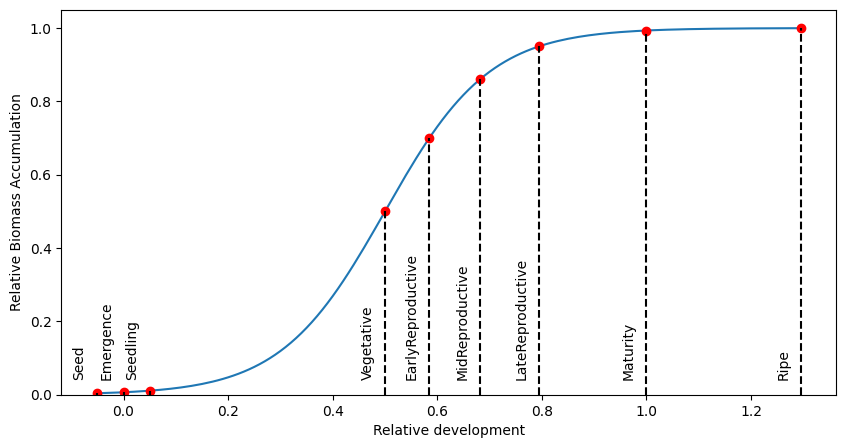

In [4]:
Graph = plt.figure(figsize=(10,5))
ax = Graph.add_subplot(1,1,1)

#Empty arrays to hold example data
BiomassScaller = []

#Relative Development series to represent x axis (0 - 1.5 in 150 steps)
RDs = pd.Series(range(round(PropnTt['Seed']*100),round(PropnTt['Ripe']*100))).divide(100)

#Calculate biomass at each Tt in the series
for r in RDs:
    BiomassScaller.append(1/(1+np.exp(-(r-Xo_Biomass)/b_Biomass)))

# Plot standard Biomass curve
plt.plot(RDs,BiomassScaller)

#Step through each stage and plot x position
for s in Stages:
    y = PropnMaxDM[s]
    x = PropnTt[s]
    plt.plot(x,y,'o',color='r')
    plt.plot([x]*2,[0,y],'--',color='k')
    plt.text(x-.02,0.05,s,rotation=90,ha = 'right')
plt.ylim(0,1.05)
plt.ylabel('Relative Biomass Accumulation')
plt.xlabel('Relative development')
plt.savefig("SCRUM_Development.jpg")

## Derive height, cover and root depth patterns

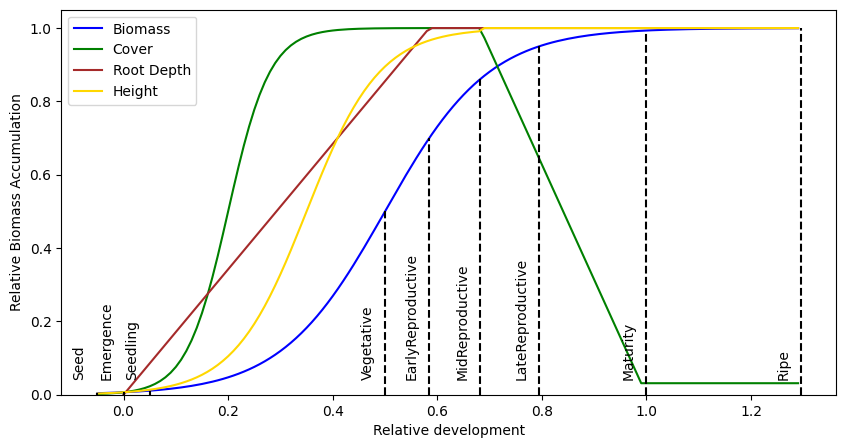

In [5]:
Graph = plt.figure(figsize=(10,5))
ax = Graph.add_subplot(1,1,1)

CoverScaller = []
RootDepthScaller = []
HeightScaller = []

Tt_maxRD = PropnTt["EarlyReproductive"]*Tt_EmergtoMat
Tt_maxHeight = PropnTt["MidReproductive"]*Tt_EmergtoMat
Tt_sen = PropnTt["MidReproductive"]*Tt_EmergtoMat
Xo_cov = Xo_Biomass * 0.4 
b_cov = Xo_cov * 0.2
Xo_hig = Xo_Biomass * 0.7
b_hig = Xo_hig *.2

for tt in RDs:
    if tt < Tt_maxRD:
        rd = tt/Tt_maxRD
    else:
        if tt < Tt_EmergtoMat:
            rd = 1.0
    RootDepthScaller.append(rd)
    if tt < Tt_sen:
        cover = 1/(1+np.exp(-(tt-Xo_cov)/b_cov))
        height = 1/(1+np.exp(-(tt-Xo_hig)/b_hig))
    else:
        if tt < Tt_EmergtoMat:
            cover = (1-(tt-Tt_sen)/(Tt_EmergtoMat-Tt_sen))
            height = 1.0
    CoverScaller.append(cover)
    HeightScaller.append(height)
    
plt.plot(RDs,BiomassScaller,color='b',label='Biomass')
plt.plot(RDs,CoverScaller,color='g',label='Cover')
plt.plot(RDs,RootDepthScaller,color='brown',label='Root Depth')
plt.plot(RDs,HeightScaller,color='gold',label = 'Height')
for s in Stages:
    y = PropnMaxDM[s]
    x = PropnTt[s]*Tt_EmergtoMat
    plt.plot([x]*2,[0,y],'--',color='k')
    plt.text(x-.02,0.05,s,rotation=90,ha = 'right')
plt.ylabel('Relative Biomass Accumulation')
plt.xlabel('Relative development')
plt.ylim(0,1.05)
plt.legend()
plt.savefig("SCRUM_Patterns.jpg")

## Derive parameters from known establish and harvest stages and Tt between the two

In [6]:
def sigmoid(ttEstabToHarv,Xo_Biomass,b_Biomass):
    return 1/(1+np.exp(-(ttEstabToHarv-Xo_Biomass)/(b_Biomass)))

In [7]:
#Known inputs
def calcScallers(EstabStage,HarvestStage,ttEstabToHarv):

    PropnTt_EstToHarv = PropnTt[HarvestStage]-PropnTt[EstabStage]
    Tt_EmergtoMat = ttEstabToHarv * 1 / PropnTt_EstToHarv
    Xo_Biomass = Tt_EmergtoMat * .5
    b_Biomass = Xo_Biomass * bFac
    
    # Derive other variables
    Xo_cov = Xo_Biomass * 0.4
    b_cov = Xo_cov * bFac
    Xo_hig = Xo_Biomass * 0.7
    b_hig = Xo_hig * bFac
    T_maxRD = PropnTt["EarlyReproductive"]*Tt_EmergtoMat
    T_maxHeight = PropnTt["MidReproductive"]*Tt_EmergtoMat
    T_sen = PropnTt["MidReproductive"]*Tt_EmergtoMat
    
    ttPreEstab = round(PropnTt[EstabStage] * Tt_EmergtoMat + (-PropnTt['Seed'] * Tt_EmergtoMat))
    Tts = range(1000)
    
    irm = 1/sigmoid(ttEstabToHarv + ttPreEstab, Xo_Biomass,b_Biomass)
    Scallers = pd.DataFrame(index=range(len(Tts)))
    for i in Scallers.index:
        t = Tts[i]
        Scallers.loc[i,'Biom'] = sigmoid(t+ttPreEstab,Xo_Biomass,b_Biomass) * irm
        if t < T_maxRD:
            rd = t/T_maxRD
        else:
            if t < Tt_EmergtoMat:
                rd = 1.0
            else:
                rd = 0.0
        Scallers.loc[i,'RD'] = rd
        if t < T_sen:
            cover = sigmoid(t,Xo_cov,b_cov)
            height = sigmoid(t,Xo_hig,b_hig)
        else:
            if t < Tt_EmergtoMat:
                cover = (1-(t-T_sen)/(Tt_EmergtoMat-T_sen))
                height = 1.0
            else:
                cover = 0
                height = 0
        Scallers.loc[i,'Cover'] = cover
        Scallers.loc[i,'Height'] = height
    return Scallers


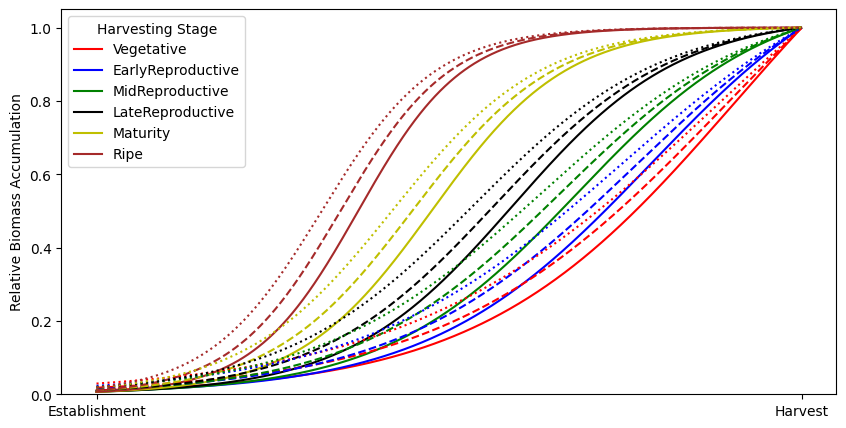

In [8]:
Graph = plt.figure(figsize=(10,5))
ax = Graph.add_subplot(1,1,1)
lines = ['-','--',':']
colors = ['r','b','g','k','y','brown']
pos = 0
for EstabStage in ['Seed','Emergence','Seedling']:
    ttEstabToHarv = 1000
    cpos=0
    for HarvestStage in ['Vegetative','EarlyReproductive','MidReproductive','LateReproductive','Maturity','Ripe']:
            
        if EstabStage == 'Seed':
            lab = HarvestStage
        else:
            lab = None
        scallers = calcScallers(EstabStage,HarvestStage,ttEstabToHarv) 
        plt.plot(scallers.index,scallers.loc[:,'Biom'] ,lines[pos], color=colors[cpos],label=lab)
        cpos+=1
    pos +=1
plt.ylabel('Relative Biomass Accumulation')
plt.ylim(0,1.05)
ax.set_xticks([0,1000], ['Establishment','Harvest'], rotation='horizontal')
#plt.plot([-50,ttEstabToHarv],[1,1],'-',color='k')
plt.legend(title = 'Harvesting Stage')
plt.savefig("SCRUM_Scaling.jpg")

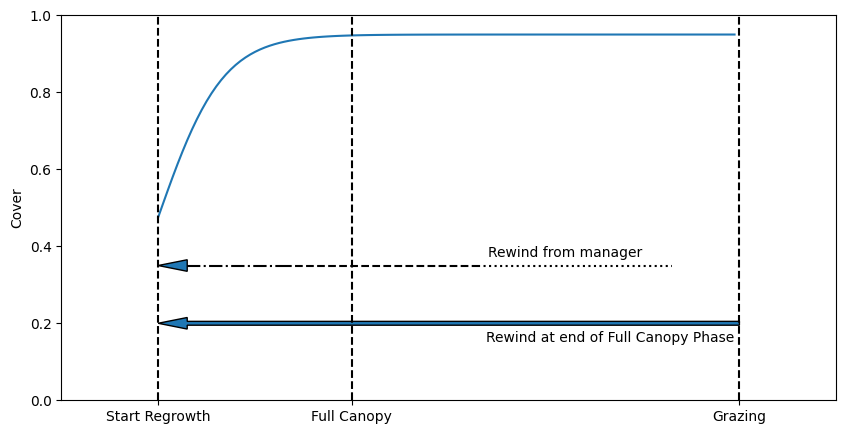

In [83]:
graph = plt.figure(figsize=(10,5))
ax = graph.add_subplot(1,1,1)
xs = range(0,600,5)
covers = [cover(x,200,0.5,0.95) for x in xs]
plt.plot(xs,covers,'-')

ax.set_xticks([0,200,600], ['Start Regrowth','Full Canopy','Grazing'], rotation='horizontal')
plt.ylim(0,1)
plt.xlim(-100,700)
plt.text(595,0.18,'Rewind at end of Full Canopy Phase',horizontalalignment='right',verticalalignment='top')
plt.text(500,0.4,'Rewind from manager',horizontalalignment='right',verticalalignment='top')
plt.ylabel('Cover')
plt.arrow(600,0.2,-600,0,width=.01,shape='full',length_includes_head=True,head_length=30)
plt.arrow(30,0.35,-30,0,width=.01,shape='full',length_includes_head=True,head_length=30)
plt.plot([30,130],[0.35,0.35],'-.',color='k')
plt.plot([130,330],[0.35,0.35],'--',color='k')
plt.plot([330,530],[0.35,0.35],':',color='k')
plt.plot([0,0],[0,1],'--',color='k')
plt.plot([200,200],[0,1],'--',color='k')
plt.plot([600,600],[0,1],'--',color='k')
plt.savefig("SPRUM_Stages.jpg")

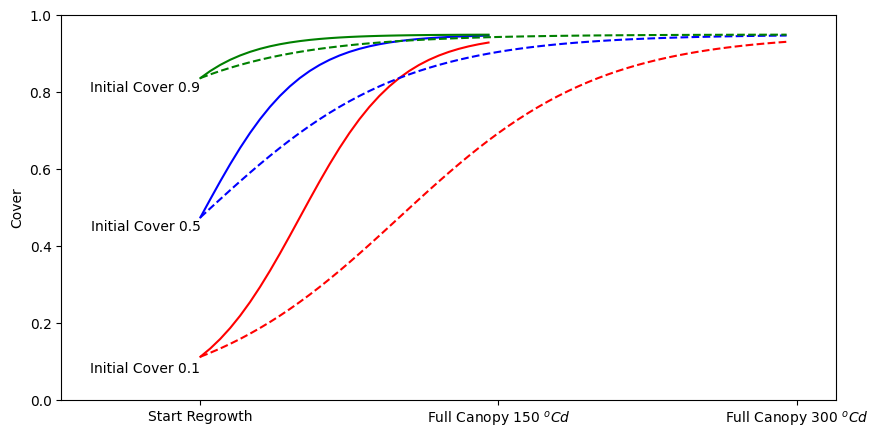

In [86]:
def cover(x, durat, initCover, ymax):
    Xo = (durat*0.3)*(0.5-initCover)*2.78
    b = durat/6
    return ymax*1/(1+np.exp(-(x-Xo)/b))
    
durats = [150,300]
initCovers = [0.1,0.5,0.9]

cols = ['r','b','g']
lins = ['-','--']

graph = plt.figure(figsize=(10,5))
ax = graph.add_subplot(1,1,1)
lpos = 0
for d in durats:
    cpos = 0
    xs = range(0,d,5)
    for i in initCovers:
        covers = [cover(x,d,i,0.95) for x in xs]
        plt.plot(xs,covers,lins[lpos],color = cols[cpos])
        cpos+=1
    lpos +=1

ax.set_xticks([0,150,300], ['Start Regrowth','Full Canopy 150 $^oCd$','Full Canopy 300 $^oCd$'], rotation='horizontal')
plt.ylim(0,1)
plt.xlim(-70,320)
plt.text(0.0,0.1,'Initial Cover 0.1',horizontalalignment='right',verticalalignment='top')
plt.text(0.0,0.47,'Initial Cover 0.5',horizontalalignment='right',verticalalignment='top')
plt.text(0.0,0.83,'Initial Cover 0.9',horizontalalignment='right',verticalalignment='top')
plt.ylabel('Cover')
plt.savefig("SPRUM_Cover.jpg")